# Data exploration

Let's take a look at the data we got from the Wikipedia CirrusSearch dump. The gzip 'content' file is 34 GB on disk, so I don't think that we want to try decompressing and reading the whole thing into memory unless we have to. Let's see if we can stream the data from the gzip archive and take a look at what we have.

**TLDR**
1. CirrusSearch 'content' dump has text and title keys
2. Reading from decompressed JSON is twice and fast as reading from the gzip archive

## 1. Setup

In [1]:
import json
import time
import matplotlib.pyplot as plt
from gzip import GzipFile

In [2]:
sample_records=5
gzip_data_file_path='./data/raw_data/enwiki-20240930-cirrussearch-content.json.gz'
json_data_file_path='./data/raw_data/enwiki-20240930-cirrussearch-content.json'


## 2. Load data sample
### 2.1. Content CirrusSearch dump

In [3]:
# Load a few records for inspection
file_stream=GzipFile(gzip_data_file_path)
records = []

for i in range(sample_records):

    line=next(file_stream)
    record=json.loads(line)
    records.append(record)

print(f'Loaded {len(records)} records from gzip archive.')
print(f'Record is: {type(records[0])}')

print(f'\nRecord 0 contains:')

for key, value in records[0].items():
    print(f' {key}: {value}')


Loaded 5 records from gzip archive.
Record is: <class 'dict'>

Record 0 contains:
 index: {'_type': '_doc', '_id': '1000'}


OK, looks like the first line in the file is just some metadata. Let's look at the second record.

In [4]:
print(f'\nRecord 1 keys:')

for key in records[1].keys():
    print(f' {key}')


Record 1 keys:
 version
 wiki
 page_id
 namespace
 namespace_text
 title
 timestamp
 create_timestamp
 redirect
 category
 external_link
 outgoing_link
 template
 text
 source_text
 text_bytes
 content_model
 coordinates
 language
 heading
 opening_text
 auxiliary_text
 defaultsort
 file_text
 display_title
 wikibase_item
 popularity_score
 weighted_tags


More like what we were expecting. We have keys for title, text, timestamp, language, even popularity score? Didn't know Wikipedia had that. Here is the title and some text from the first record:

In [5]:
text_sample = ' '.join(records[1]['text'].split(' ')[:100])

print(f"Title: {records[1]['title']}")
print(f'Text\n{text_sample}')

Title: Hercule Poirot
Text
Hercule Poirot (UK: /ˈɛərkjuːl ˈpwɑːroʊ/, US: /hɜːrˈkjuːl pwɑːˈroʊ/) is a fictional Belgian detective created by British writer Agatha Christie. Poirot is one of Christie's most famous and long-running characters, appearing in 33 novels, two plays (Black Coffee and Alibi), and 51 short stories published between 1920 and 1975. Poirot has been portrayed on radio, in film and on television by various actors, including Austin Trevor, John Moffatt, Albert Finney, Peter Ustinov, Ian Holm, Tony Randall, Alfred Molina, Orson Welles, David Suchet, Kenneth Branagh, and John Malkovich. Poirot's name was derived from two other fictional detectives of the time: Marie Belloc


Yep, that's a Wikipedia article. Good, I think we can work with this. The text is really what we are after but what was in the 'general' dump?

### 2.2. General CirrusSearch dump

In [6]:
# Load a few records for inspection
file_stream=GzipFile('./data/raw_data/enwiki-20240930-cirrussearch-general.json.gz')
records = []

for i in range(sample_records):

    line=next(file_stream)
    record=json.loads(line)
    records.append(record)

print(f'Loaded {len(records)} records from gzip archive.')
print(f'Record is: {type(records[0])}')

print(f'\nRecord 0 contains:')

for key, value in records[0].items():
    print(f' {key}: {value}')

Loaded 5 records from gzip archive.
Record is: <class 'dict'>

Record 0 contains:
 index: {'_type': '_doc', '_id': '100000'}


Looks like the same metadata that was in the content dump. Let's take a look at the second record.

In [7]:
print(f'\nRecord 1 keys:')

for key in records[1].keys():
    print(f' {key}')


Record 1 keys:
 template
 content_model
 wiki
 auxiliary_text
 language
 title
 ores_articletopics
 page_id
 create_timestamp
 weighted_tags
 text
 timestamp
 redirect
 heading
 source_text
 version_type
 coordinates
 version
 external_link
 namespace_text
 namespace
 text_bytes
 incoming_links
 category
 outgoing_link


It looks the same, but the file is bigger - maybe this includes other pages besides just 'content' pages? This might need some research.

## 3. Record read rate: gzip vs JSON
Since the unzipped files are too big to fit in memory, let's first see if there is any time benefit to streaming the data from the gzip archive vs the decompressed JSON file. We have two ways we can read the data:

1. From the gzip archive
2. From the decompressed JSON

Which one is faster? By how much? There is obviously an advantage to reading straight from the archive. Let's read a bunch of records and time it.

In [8]:
# Run replicates of chunks
replicates=100
chunk_size=5000

# And collect the read rate in records per second
# for each chunk
gzip_read_rates=[]
json_read_rates=[]

# Time gzip reads

# Open gzip JSON lines file stream
file=GzipFile(gzip_data_file_path)

# Always skip the first metadata line
_=next(file)

# Loop on replicates
while len(gzip_read_rates) < replicates:

    # Time how long it takes to load each chunk of records
    start_time=time.time()

    for i in range(chunk_size):
        line=next(file)
        record=json.loads(line)
    
    dT=time.time() - start_time
    gzip_read_rates.append(chunk_size / dT)

# Print the result
mean_gzip_read_rate=sum(gzip_read_rates) / len(gzip_read_rates)
print(f'Mean gzip read rate: {mean_gzip_read_rate:.0f} records per second')

# Time JSON reads

# Open the JSON file
with open(json_data_file_path, 'r') as file:

    # Always skip the first metadata line
    _=next(file)

    # Loop on replicates
    while len(json_read_rates) < replicates:

        # Time how long it takes to load each chunk of records
        start_time=time.time()
    
        # Iterate over the lines
        for i, line in enumerate(file):

            record=json.loads(line)

            if i == chunk_size:
                dT=time.time() - start_time
                json_read_rates.append(chunk_size / dT)
                break

# Print the result
mean_json_read_rate=sum(json_read_rates) / len(json_read_rates)
print(f'Mean JSON read rate: {mean_json_read_rate:.0f} records per second', end='')

Mean gzip read rate: 5937 records per second
Mean JSON read rate: 10582 records per second

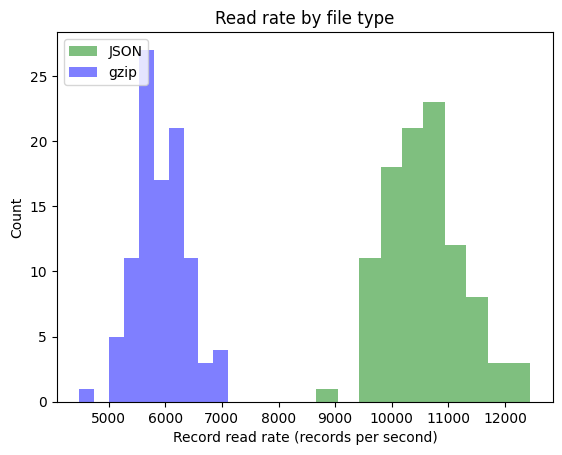

In [9]:
plt.title('Read rate by file type')

plt.hist(
    json_read_rates,
    facecolor = 'green',
    label = 'JSON',
    alpha = 0.5
)

plt.hist(
    gzip_read_rates,
    facecolor = 'blue',
    label = 'gzip',
    alpha = 0.5
)

plt.legend(loc = 'upper left')
plt.xlabel(f'Record read rate (records per second)')
plt.ylabel('Count')
plt.show()

Reading from the decompressed file is a little less than twice as fast as reading from the gzip archive. No big surprise there. Now let's try reading the whole file - we still don't even know how many records we have!

## 4. Dataset size and read time

### 4.1. Read lines only

In [10]:
%%time

# Open the JSON file
with open(json_data_file_path, 'r') as file:

    # Always skip the first metadata line
    _=next(file)
    
    # Iterate over the lines
    for i, line in enumerate(file):

        # Print a status update every 1000 lines
        if i % 1000 == 0:
            print(f'Read {i} lines', end= '\r')

print(f'Read {i} lines total\n')

Read 13778448 lines total

CPU times: user 1min 35s, sys: 54.8 s, total: 2min 30s
Wall time: 2min 36s


Not terrible, we have 13.8 million records, and it took us about two and a half minutes to visit each one. Let's try it again and see how much we slow down if we load each one to JSON and grab the text.

### 4.2. Load JSON to dictionary

In [11]:
%%time

# Track the number of times we catch KeyError, or 
# the number of times a record does not have a 'text' key
keyerror_count=0

# Open the JSON file
with open(json_data_file_path, 'r') as file:
    
    # Always skip the first metadata line
    _=next(file)
    
    # Iterate over the lines
    for i, line in enumerate(file):

        record=json.loads(line)

        try:
            text=record['text']

        except KeyError as e:
            keyerror_count+=1

        # Print a status update every 1000 lines
        if i % 1000 == 0:
            print(f'Read {i} lines', end= '\r')

print(f'Read {i} lines total')
print(f'{keyerror_count} records don\'t have a text key\n')

Read 13778448 lines total
6889224 records don't have a text key

CPU times: user 19min 4s, sys: 1min 1s, total: 20min 6s
Wall time: 20min 7s


Actually reading the JSON into a dictionary increases the total time by a factor of 8, but it still takes less than a half hour to read the whole file. Not terrible if we only need to do this one to parse the text out and batch it.

But look at the 'text' key-less record count, it's much more than I thought... Wait, it's exactly half. I bet I know what is going on - only every other line is an article because each one comes with that metadata/header line we saw was the first line in the file. OK, I bet we can speed up a good bit by only looking at every other line.

In [12]:
%%time

# Track the number of times we catch KeyError, or 
# the number of times a record does not have a 'text' key
keyerror_count=0

# Open the JSON file
with open(json_data_file_path, 'r') as file:
    
    # Iterate over the lines
    for i, line in enumerate(file):

        # Skip even numbered header lines and only
        # attempt a load on odd numbered article lines
        if i % 2 != 0:

            # Load the line to JSON
            record=json.loads(line)

            # Get the text, catching KeyError if the
            # JSON dictionary has no 'text' key
            try:
                text=record['text']

            # Count key errors
            except KeyError as e:
                keyerror_count+=1
            
        # Print a status update every 5000 lines
        if i % 5000 == 0:
            print(f'Read {i} lines', end= '\r')

print(f'Read {i} lines total')
print(f'{keyerror_count} records don\'t have a text key\n')

Read 13778449 lines total
0 records don't have a text key

CPU times: user 18min 23s, sys: 1min 3s, total: 19min 27s
Wall time: 19min 29s


OK, well, it didn't speed up any, which is a little strange. But, at least we are not catching any KeyErrors when we extract the text. Feels cleaner. OK. Time to move on.

## 6. Conclusion

Reading straight from the gzip archive halves the read rate compared to reading uncompressed JSON. However, even with the compressed data we are looking a less than an hour to process the whole file. Remember, we only need to read from the raw data once to extract the text to batches.